## Step 1 - Imports

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")
RANDOM_STATE = 42

## Step 2 - Load dataset

In [45]:
DATA_FILE = "House_Price_India_data.csv"   # make sure this file is in current folder
df = pd.read_csv(DATA_FILE)
print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Standardize column names to lower-case & strip
df.columns = df.columns.str.lower().str.strip()

Loaded dataset shape: (1000, 6)
Columns: ['area', 'bedrooms', 'location', 'built_year', 'age', 'price']


## Step 3 - Pandas for feature engineering

In [46]:
# Price per square foot
df['price_per_sqft'] = df['price'] / df['area']

print("\nAfter engineering, sample rows:")
print(df.head())


After engineering, sample rows:
   area  bedrooms  location  built_year  age   price  price_per_sqft
0  2170         4    122029        2001   24  546800      251.981567
1  2230         4    122012        2016    9  550000      246.636771
2  1720         3    122014        1996   29  399950      232.529070
3  2080         4    122026        1996   29  940000      451.923077
4  3160         4    122069        2000   25  545000      172.468354


## Step 4 - Visualize features vs price with Matplotlib

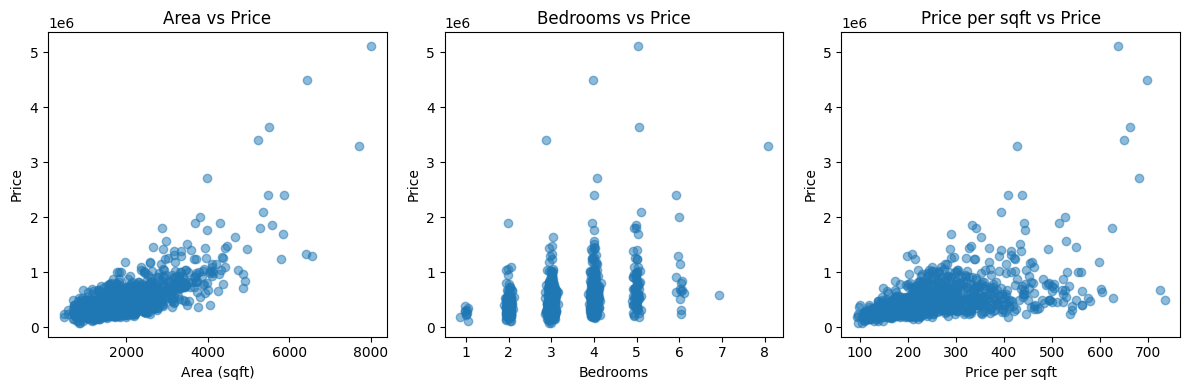

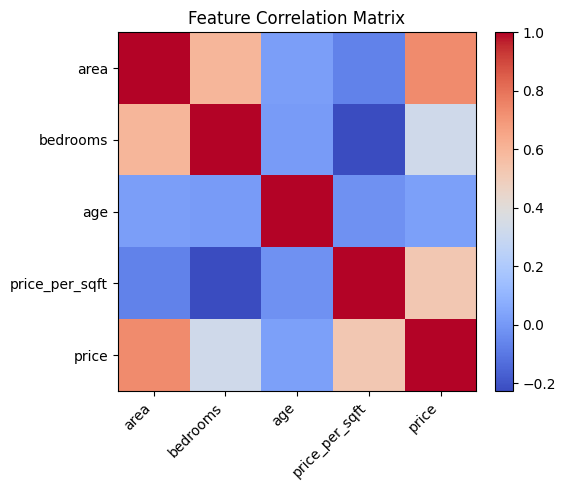


Correlation matrix:
                     area  bedrooms       age  price_per_sqft     price
area            1.000000  0.595877  0.022232       -0.069953  0.735080
bedrooms        0.595877  1.000000  0.012249       -0.226073  0.329398
age             0.022232  0.012249  1.000000       -0.021338  0.025839
price_per_sqft -0.069953 -0.226073 -0.021338        1.000000  0.522169
price           0.735080  0.329398  0.025839        0.522169  1.000000


In [47]:
plt.style.use('default')

# Scatter: area vs price
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(df['area'], df['price'], alpha=0.5)
plt.xlabel('Area (sqft)')
plt.ylabel('Price')
plt.title('Area vs Price')

# Scatter: bedrooms vs price 
plt.subplot(1,3,2)
x = df['bedrooms'] + np.random.normal(0, 0.05, size=len(df))
plt.scatter(x, df['price'], alpha=0.5)
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.title('Bedrooms vs Price')

# Scatter: price_per_sqft vs price
plt.subplot(1,3,3)
plt.scatter(df['price_per_sqft'], df['price'], alpha=0.5)
plt.xlabel('Price per sqft')
plt.ylabel('Price')
plt.title('Price per sqft vs Price')

plt.tight_layout()
plt.show()

# Correlation heatmap 
corr = df[['area', 'bedrooms', 'age', 'price_per_sqft', 'price']].corr()
fig, ax = plt.subplots(figsize=(6,5))
cax = ax.imshow(corr, interpolation='nearest', cmap='coolwarm')
ax.set_xticks(range(len(corr.columns))); ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.index)
fig.colorbar(cax, fraction=0.046, pad=0.04)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nCorrelation matrix:\n", corr)

## Step 5 - Train a Regression model in Scikit-learn

In [48]:
# Prepare features: numeric + one-hot location
X_num = df[['area', 'bedrooms', 'age', 'price_per_sqft']].copy()
X_loc = pd.get_dummies(df['location'].astype(str), prefix='loc', drop_first=True)
X = pd.concat([X_num, X_loc], axis=1)
y = df['price']

print("\nFeature matrix shape:", X.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# 4a) Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"\nLinear Regression -> RMSE: {rmse_lr:.2f}, R²: {r2_lr:.4f}")

# 4b) Random Forest (basic fit)
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
# Simple grid search example (quick)
param_grid = {'n_estimators':[100], 'max_depth':[10, 20, None]}
gs = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=0)
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_
y_pred_rf = best_rf.predict(X_test)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest (best) -> params: {gs.best_params_}")
print(f"Random Forest -> RMSE: {rmse_rf:.2f}, R²: {r2_rf:.4f}")



Feature matrix shape: (1000, 73)

Linear Regression -> RMSE: 160956.06, R²: 0.8266
Random Forest (best) -> params: {'max_depth': 10, 'n_estimators': 100}
Random Forest -> RMSE: 92154.87, R²: 0.9432


In [49]:
# Optional: feature importance from Random Forest
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nTop feature importances:\n", feat_imp.head())


Top feature importances:
 area              0.615837
price_per_sqft    0.359583
loc_122010        0.005278
loc_122071        0.005135
bedrooms          0.005002
dtype: float64


## Step 6 - Choose the best model and save the model

In [50]:
import joblib

# compare RMSE values from your training results
if rmse_rf <= rmse_lr:
    best_model = best_rf
    model_name = "RandomForestRegressor"
else:
    best_model = lr
    model_name = "LinearRegression"

print(f"✅ Selected best model: {model_name}")

# Save the model to a .pkl file
joblib.dump(best_model, "house_price_model.pkl")

# Save the feature column names (exact order)
joblib.dump(list(X.columns), "model_feature_columns.pkl")

print("💾 Model and feature columns saved successfully!")
print("Files created:")
print(" - house_price_model.pkl")
print(" - model_feature_columns.pkl")

✅ Selected best model: RandomForestRegressor
💾 Model and feature columns saved successfully!
Files created:
 - house_price_model.pkl
 - model_feature_columns.pkl
